# Random Forest Modeling of NMR Spectral Bins/Features

In [1]:
from collections import defaultdict
from pathlib import Path
import re
from subprocess import call
import time

from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.tree import export_graphviz
from tqdm.notebook import tqdm

## Load and prep data

In [2]:
# read csv files of binned spectra an smaple labels
nmr_data = pd.read_csv("/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/output/MTBLS430_bin500_for_sig_tests.csv", index_col=0)

In [3]:
phenotype_columns = {
    'MTBLS430': 'Factor_Value_Treatment',
}

phenotype_titles = {
    'MTBLS430': 'Treatment Type',
}
phenotype = "MTBLS430"

In [4]:
# set figure resolution
mpl.rcParams['figure.dpi'] = 320

# Set a random seed
RANDOM_STATE = 1855

Each file contains 'X' (a sample ID), some phenotype columns, and many value columns.

### Data

"X9.9897859964628" is the intensity at position 9.9897859964628.  These data columns are extracted using a regular expression.  
### Phenotype

Each dataset has it's own phenotype of interest.  All are categorical.

# Functions used in this analysis

## Splitting data and validating classifiers

In [5]:
data_col_pattern = re.compile("X[0-9]\.[0-9]+")


def split_data(df, dataset_name):
    """Return an outcome (y) Series and a data (X) DataFrame, logging some information"""
    X = df[[c for c in df.columns if data_col_pattern.fullmatch(c) is not None]]
    other = df[[c for c in df.columns if data_col_pattern.fullmatch(c) is None]]
    y = other[phenotype_columns[dataset_name]].astype('category')
    print(dataset_name)
    print('-'*len(dataset_name))
    print(y.value_counts())
    print(f"\n{len(X.columns):,} datapoints")

    return X, y

def cross_validate_classifier(clf, X, y, cv=10):
    """Wrapper around the cross_validate function to conviently handle the returned data"""
    results = cross_validate(clf, X, y, cv=cv, return_estimator=True, n_jobs=-1)
    # Log relevant info
    print(f"Average training time = {results['fit_time'].mean():.2} seconds")
    print(f"Average test scoring time = {results['score_time'].mean():.2} seconds")
    print(f"Test Scores: {results['test_score']}")      
    scores = results['test_score']
    fitted_clfs = results['estimator']
    return scores, fitted_clfs

## Feature importance and selection

In [6]:
def collect_cv_gini_importance(X, fitted_clf_list):
    """
    Generate a dataframe of importance scores based on a list of fitted classifiers.
    """
    # Collect the importance scores into a dataframe
    dfs = []
    for idx, clf in enumerate(tqdm(fitted_clf_list)):
        df = pd.DataFrame({'Spectral_Bin': list(X.columns), 'CV': idx, 'Importance':clf.feature_importances_})
        dfs.append(df)
    df = pd.concat(dfs)
    
    # Index and Sort
    df = df.set_index(['Spectral_Bin', 'CV'])
    df.sort_values(by='Importance', ascending=False)
    return df


def generate_cv_permutation_importance(X, y, fitted_clf_list, n_repeats=10):
    """
    Generate a dataframe of permutation importance scores based on a list of fitted classifiers.
    """
    # Collect the importance scores into a dataframe
    dfs = []
    for idx, clf in enumerate(tqdm(fitted_clf_list)):
        permutation_scores = permutation_importance(clf, X, y, n_repeats=n_repeats, n_jobs=-1)['importances_mean']
        df = pd.DataFrame({'Spectral_Bin': list(X.columns), 'CV': idx, 'Importance':permutation_scores})
        dfs.append(df)
    df = pd.concat(dfs)
    
    # Index and Sort
    df = df.set_index(['Spectral_Bin', 'CV'])
    df.sort_values(by='Importance', ascending=False)
    return df    


def select_features(importances, explained_proportion=0.9, plot_histogram=True):
    """
    Extract a subset of features explaining at least 'explained_proportion' of importance.
    Take the median value across CVs
    """
    # Separate importances out into columns
    median_importances = importances.unstack(level='CV').median(axis=1).sort_values(ascending=False)
    # Take all bins until the cumulative sum is > the desired value, otherwise take all
    selected = median_importances[median_importances.cumsum() <= explained_proportion]
    # Log
    print(f"Selected {len(selected):,} of {len(median_importances):,} features, adding up to {selected.sum():.3f} importance")
    # Return a list of bin names
    return list(np.sort(selected.index.values))

## Plotting

In [7]:
def plot_spectral_data(X, row_num):
    """
    Plot the spectral data for a given row in the feature df X
    """
    # Format data
    data = X.iloc[row_num]
    sample_name = data.name
    data = data.reset_index()
    data.columns=['bin', 'intensity']
    data['position'] = data['bin'].apply(lambda s: float(s[1:]))
    # Plot
    fig, ax = plt.subplots(1)
    ax.scatter(data['position'], data['intensity'], marker='.')
    ax.set_title(f"Data for sample '{sample_name}'")
    ax.set_ylim(0, data['intensity'].max()*1.1) 

    
def plot_importance(importances_df, ax=None, title='Feature Importances'):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    for cv, subset in importances_df.groupby('CV'):
        y = subset['Importance'].sort_values(ascending=False).cumsum()
        x = range(len(y))
        ax.plot(x, y, label=f"Fold {cv}", alpha=0.9)
    ax.legend()
    ax.set_xlabel('Number of Spectral Bins', fontsize=12)
    ax.set_ylabel('Cumulative Importance', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=12)

    
def plot_roc_cv(clf, X, y, cv=10, title=None):
    """
    Plot AUC using cross-validation
    See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    """
    cv = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(1, figsize=(8, 6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(clf, X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=title)
    ax.legend(loc="lower right")
    return ax


def confusion_matrix_analysis(clf, X, Y, cv=10):
    """
    Plot a confusion matrix for each cross-fold
    """
    # Rows are Non-normalized and normalized.  Columns are each CV fold
    fig, axes = plt.subplots(2, cv, figsize=(8, 4), sharex=True, sharey=True)
        
    # Create cv object
    cv_obj = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        # Plot non-normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize=None,
                              cmap=plt.cm.Blues,
                              ax=axes[0, i],
                              xticks_rotation='vertical')
        # Plot normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize="true",
                              cmap=plt.cm.Blues,
                              ax=axes[1, i],
                              xticks_rotation='vertical')
    
    # Remove axes not in the subplot- these are the colorbars that clutter the image
    for a in fig.axes:
        if a not in axes:
            plt.delaxes(a)
    
    # Label the columns of plots
    for i in range(cv):
        axes[0, i].set_title(f"Fold {i}")
    
    plt.tight_layout()

# 1.0 CHS RF Modeling

In [8]:

X, y = split_data(nmr_data, phenotype)

MTBLS430
--------
methoxypoly(ethylene glycol)-poly(lactide-co-glycolide)polylysine    30
control                                                              30
E-NP-DTS nanoparticle                                                30
E-NP-DT nanoparticle                                                 30
E-NP-D nanoparticle                                                  30
Name: Factor_Value_Treatment, dtype: int64

457 datapoints


## 1.1 CHS: generate RF model with all features/spectral bins

In [9]:
# initialize RF classifier
clf = RandomForestClassifier(max_depth=2, n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1)

scores, clf_fitted = cross_validate_classifier(clf, X, y)

Average training time = 2.6e+01 seconds
Average test scoring time = 1.8 seconds
Test Scores: [0.53333333 0.53333333 0.66666667 0.66666667 0.86666667 0.8
 0.73333333 0.6        0.73333333 0.86666667]


## 1.2 CHS Feature selection

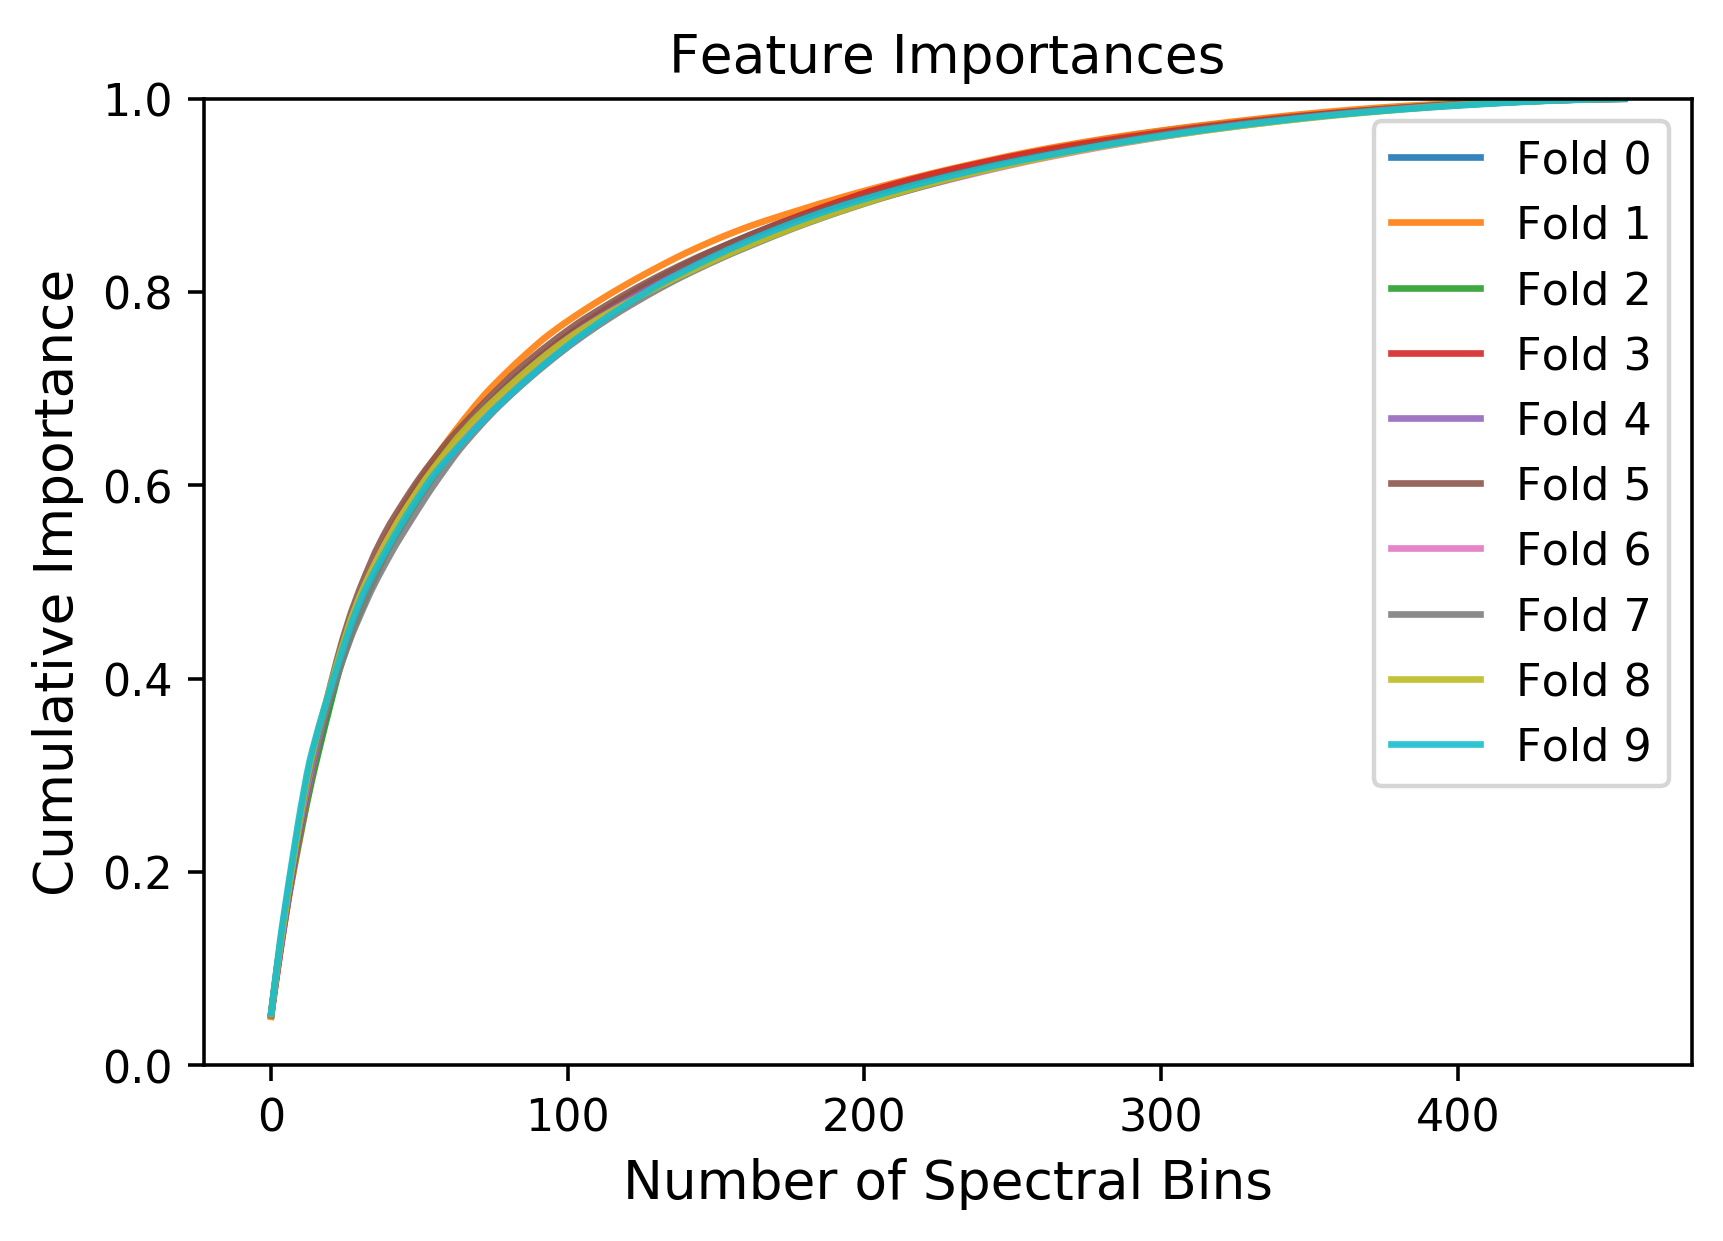

In [10]:
gini_importances = collect_cv_gini_importance(X, clf_fitted)
plot_importance(gini_importances)

Selected 245 of 457 features, adding up to 0.899 importance


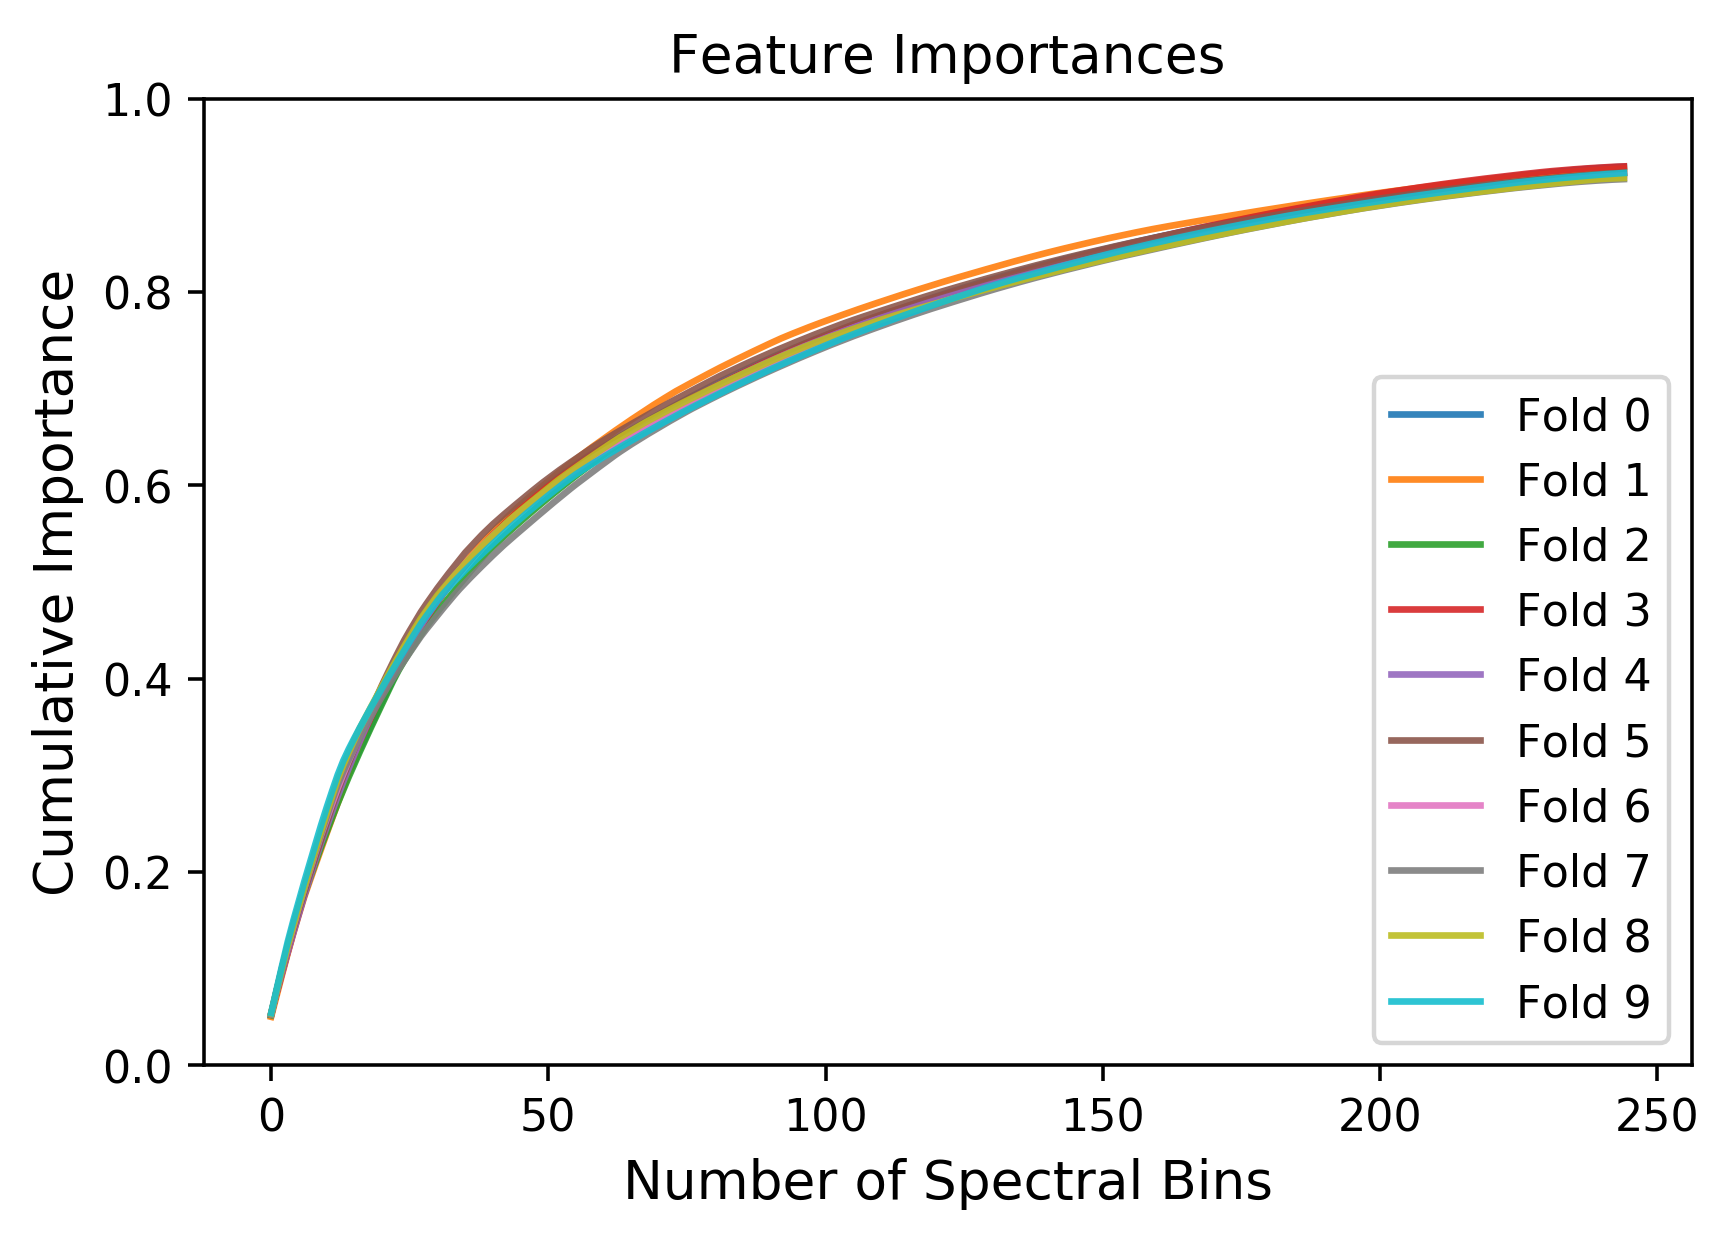

In [11]:
selected_features = select_features(gini_importances)
plot_importance(gini_importances.loc[selected_features])

## 1.3 CHS: create a second RF model with selected features

In [14]:
clf_selected = RandomForestClassifier(max_depth=2, n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1)

In [15]:
scores, clf_selected_fitted = cross_validate_classifier(clf_selected, X[selected_features], y)

Average training time = 2.5e+01 seconds
Average test scoring time = 1.7 seconds
Test Scores: [0.53333333 0.53333333 0.6        0.66666667 0.8        0.8
 0.66666667 0.6        0.8        0.86666667]


## 1.4 CHS: model performance metrics
### Feature importance

In [17]:
# Calculate permutation importances for feature-selected model, unless it has already been done
permutation_importance_file = "/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/output/{phenotype}_permutation_importances.txt"

In [ ]:
if Path(permutation_importance_file).is_file():
    permutation_importances = pd.read_csv(permutation_importance_file, sep="\t", index_col=[0, 1])
else:
    permutation_importances = generate_cv_permutation_importance(X[selected_features], y, clf_selected_fitted, n_repeats=10)
    

In [18]:
permutation_importances.to_csv(permutation_importance_file, sep="\t")

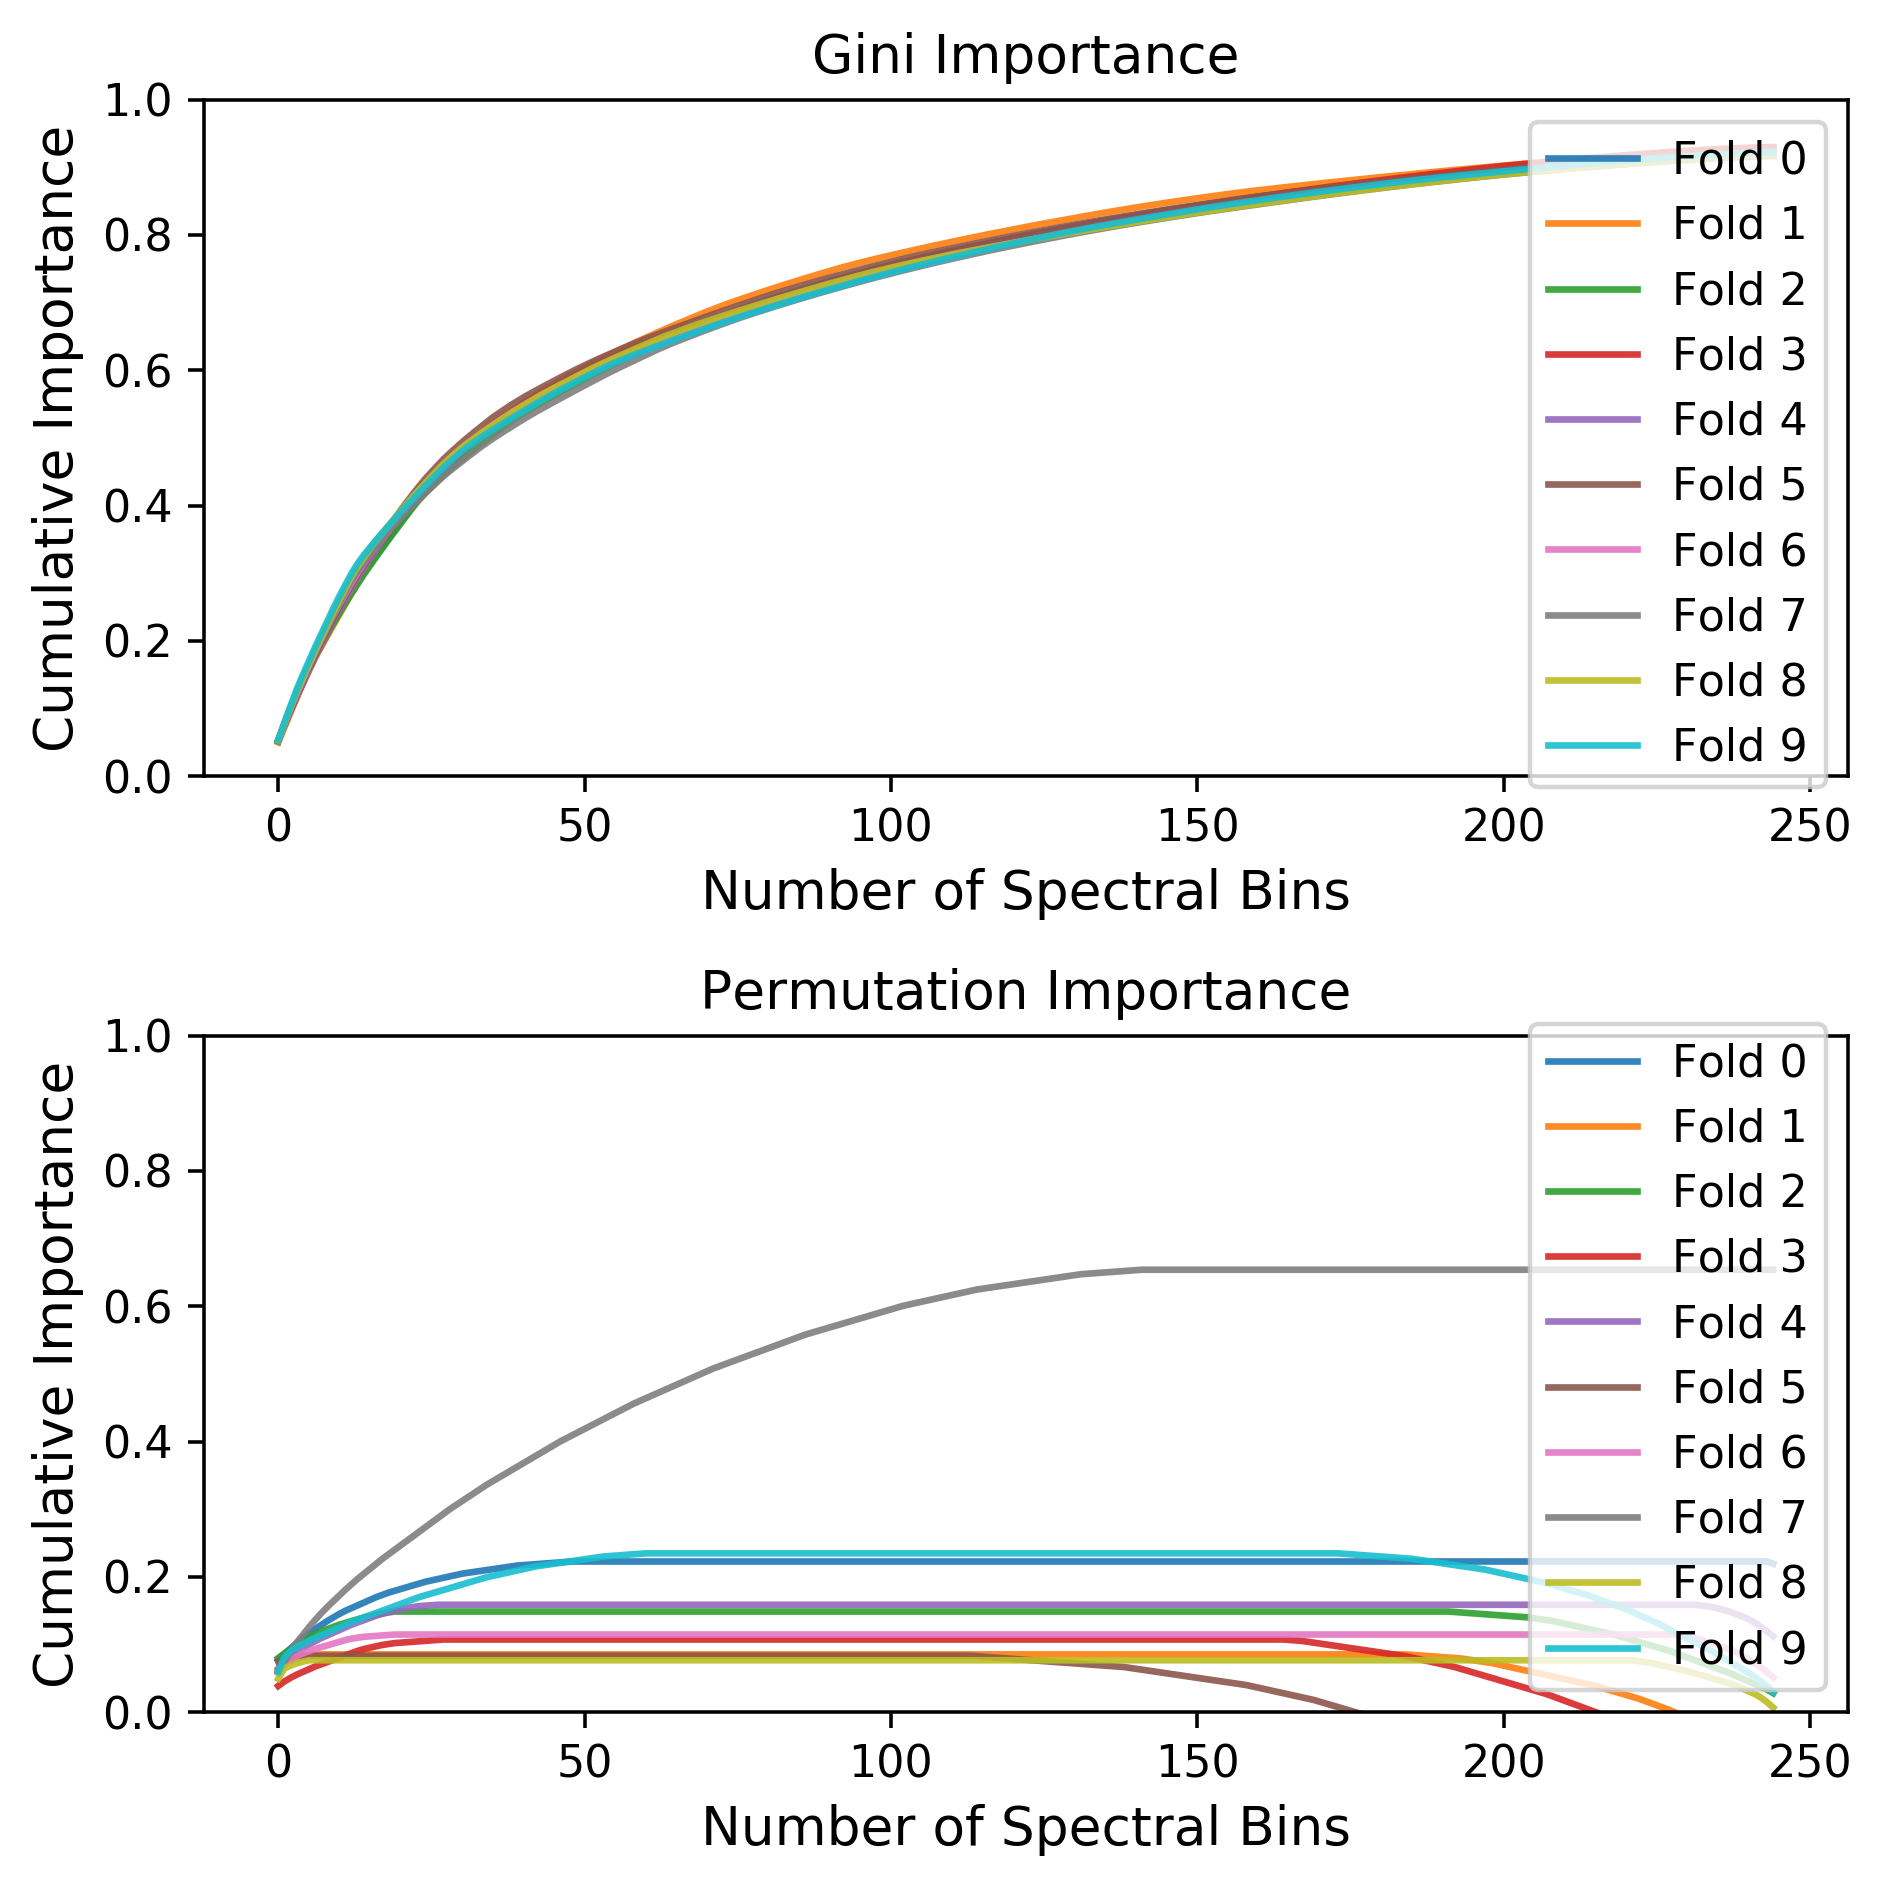

In [19]:
fig, axes = plt.subplots(2, figsize=(6, 6))
plot_importance(gini_importances.loc[selected_features], ax=axes[0], title="Gini Importance")
plot_importance(permutation_importances, ax=axes[1], title="Permutation Importance")
plt.tight_layout()

In [20]:
permutation_importances.sort_values(by="Importance", ascending=False).head()

Importance
Spectral_Bin     CV            
X3.7094453593226 2     0.080000
                 0     0.077333
                 5     0.074667
                 4     0.064667
                 1     0.061333

## 1.4 CHS: model performance metrics
### ROC curves and AUC

ValueError: RandomForestClassifier should be a binary classifer

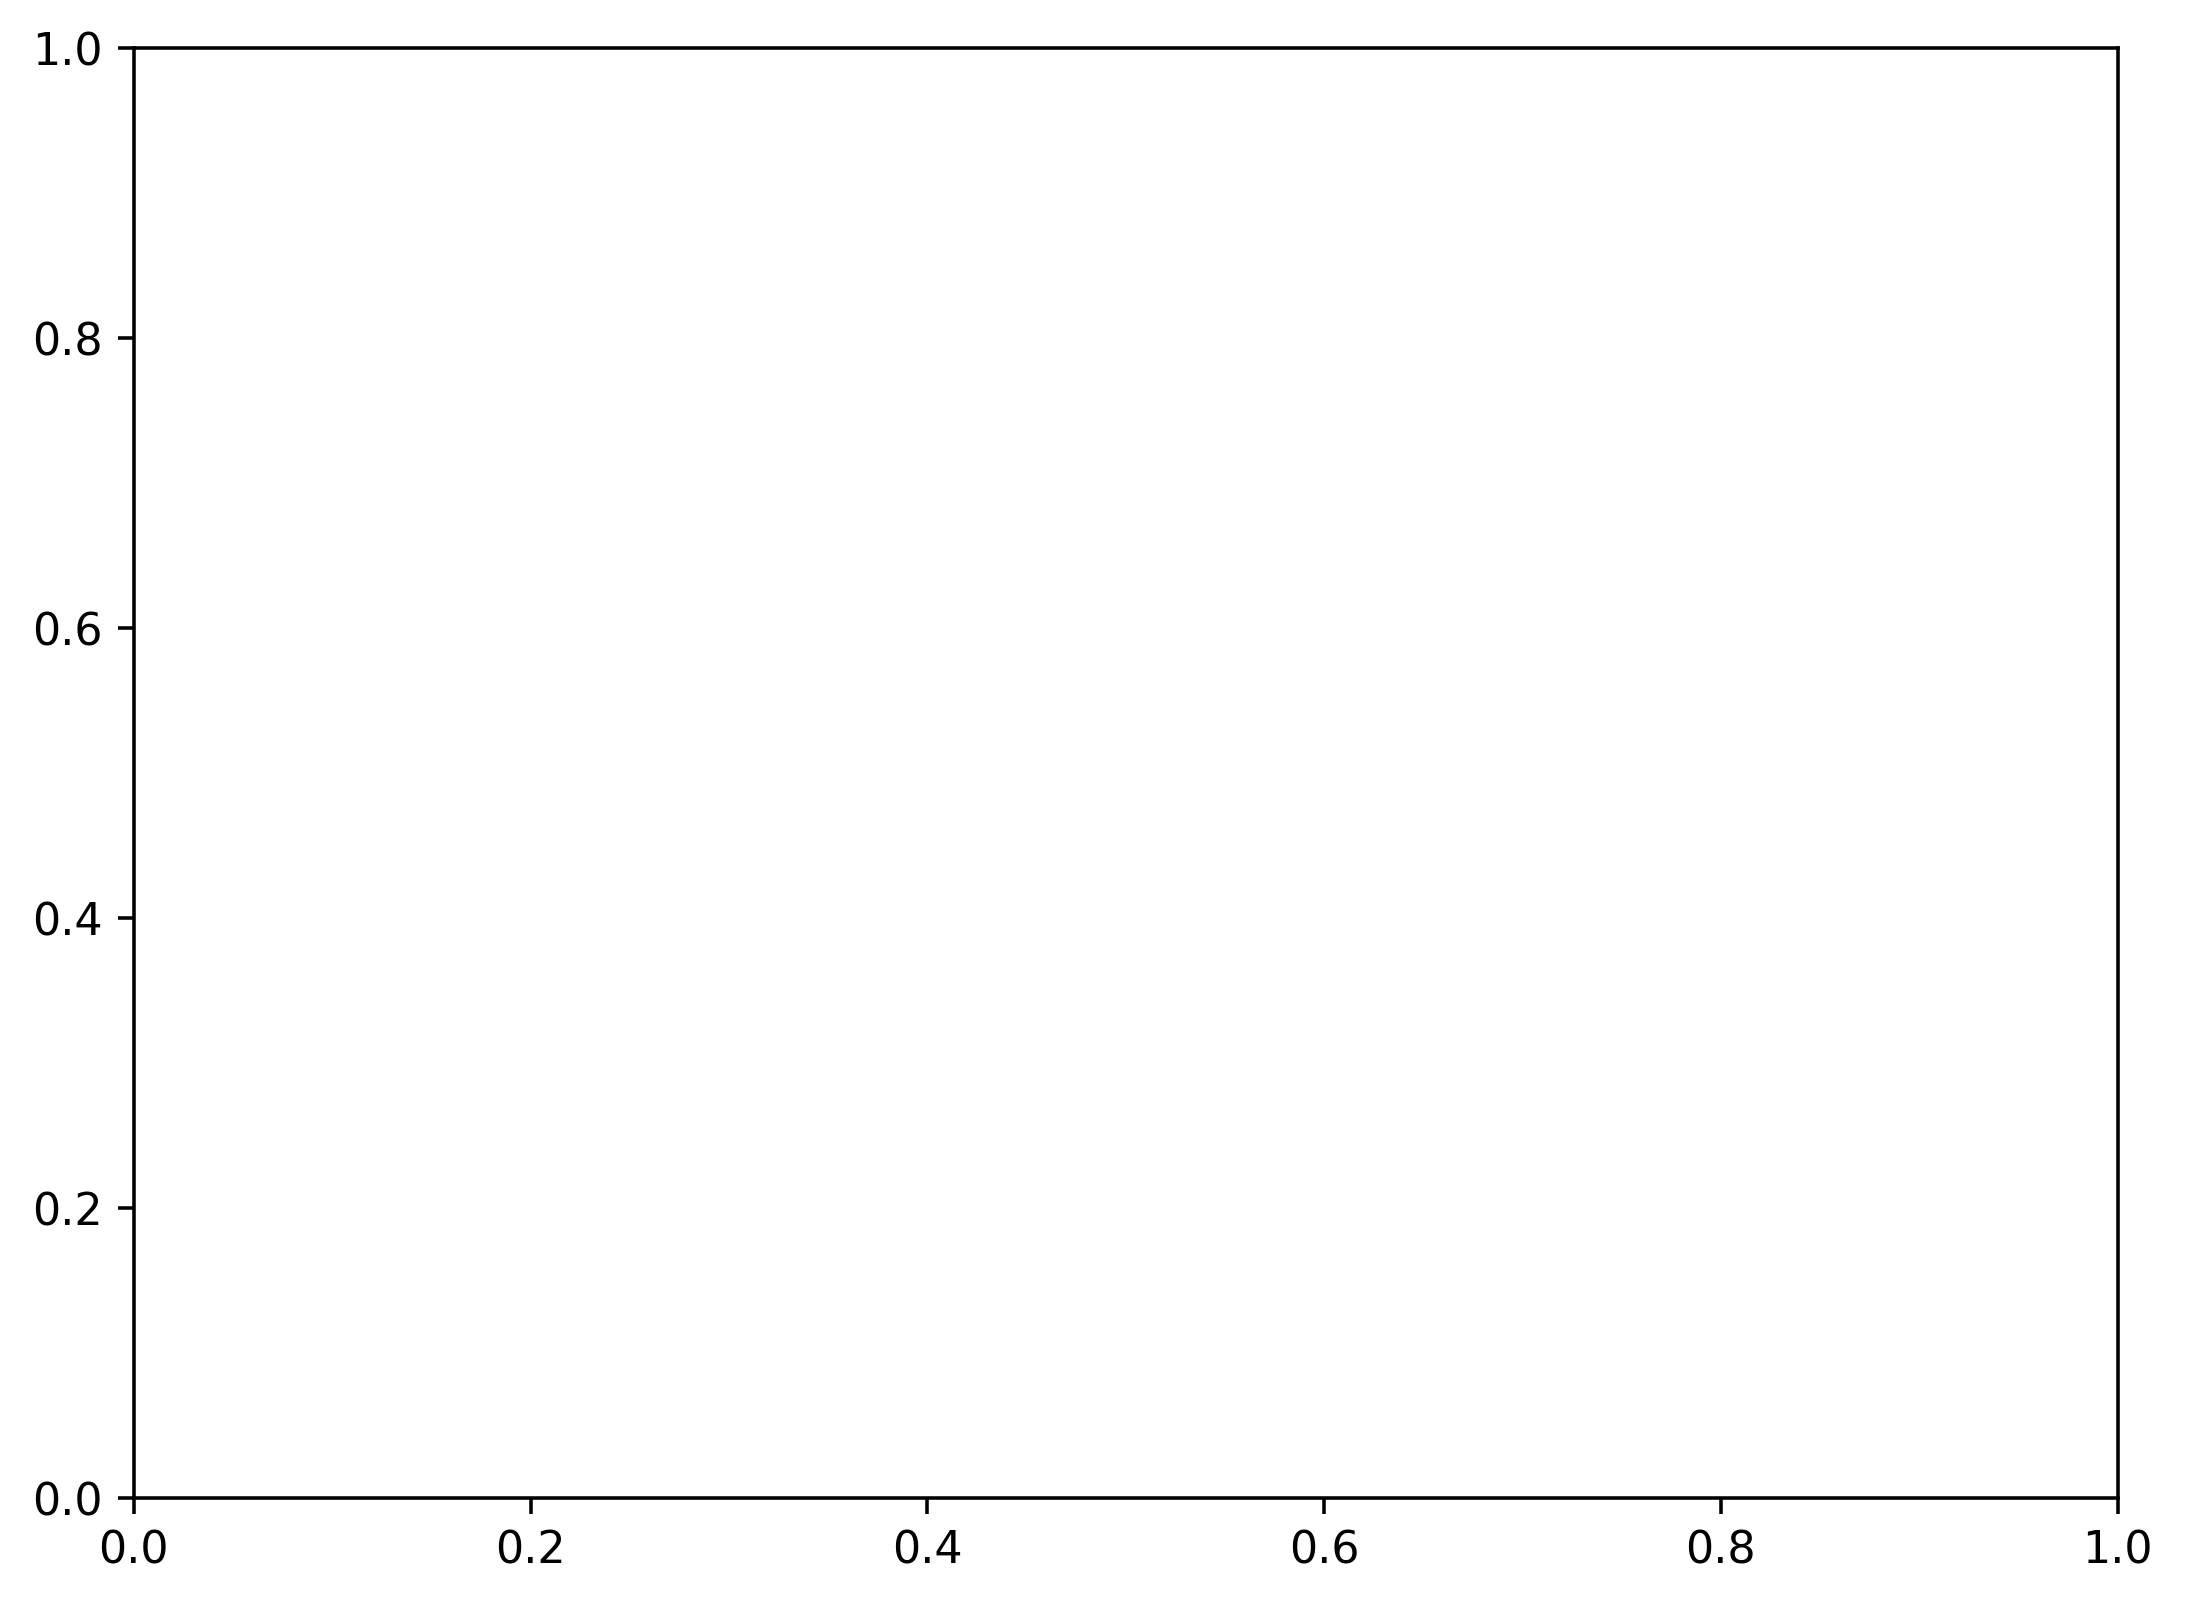

In [21]:
plot_roc_cv(clf, X, y, title=phenotype_titles[phenotype])

In [ ]:
plot_roc_cv(clf_selected, X, y, title=f"{phenotype_titles[phenotype]} (Selected Features)")

### CHS RF model without feature selection

In [ ]:
confusion_matrix_analysis(clf, X, y)

### CHS RF model WITH feature selection

In [ ]:
confusion_matrix_analysis(clf_selected, X, y)

## 1.6 RF model with selected features and class balancing

In [ ]:
clf_selected_balanced = RandomForestClassifier(max_depth=3, n_estimators=10000,
                                               random_state=RANDOM_STATE,
                                               n_jobs=-1, class_weight="balanced")

In [ ]:
scores, clf_selected_balanced_fitted = cross_validate_classifier(clf_selected_balanced, X[selected_features], y)

In [ ]:
plot_roc_cv(clf_selected_balanced, X, y, title=f"{phenotype_titles[phenotype]} (Selected Features, Balanced Classes)")

In [ ]:
confusion_matrix_analysis(clf_selected_balanced, X, y)

In [ ]:
"""
MTBLS_424_rfc_estimator = MTBLS_424_rfc.estimators_[5]

from sklearn.tree import export_graphviz
import graphviz
# Export as dot file
export_graphviz(MTBLS_424_rfc_estimator, out_file='tree.dot', 
                feature_names = np.asarray(list(MTBLS_424_X_train.columns)),
                class_names = np.unique(np.asarray((MTBLS_424_Y))),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')
"""